# Causal model selection

## Background

In this tutorial we consider two continuous and correlated variables, $X$ and $Y$, representing the expression levels of two genes. We also consider a discrete variable $Z$ representing a genotype for gene $X$. Typically, $Z$ will have been obtained by [eQTL mapping](https://en.wikipedia.org/wiki/Expression_quantitative_trait_loci) for gene $X$. We wish to determine if variation in $X$ causes variation in $Y$.

The **aim of causal model selection** is: given observational data for $Z$, $X$, and $Y$ in a set of independent samples, which causal model (represented by a directed acyclic graph) explains the data best. 

To restrict the space of possible models that need to be considered, a number of assumptions reflecting biological knowledge can be made:

1. Genetic variation influences variation in gene expression (and phenotypes more generally), but changing the value of an individual's phenotype does not change their genome. Hence, in our models there can be **no incoming arrows into $Z$**.

2. We assume that the statistical association between $Z$ and $X$ is due to a *direct* effect, that is, all causal models we consider **must contain the directed edge $Z\to X$**. This assumption is justified if $Z$ is located within or near to $X$ (on the genome) and in a known regulatory region for $X$.

3. For $X$ and $Y$ to be correlated (non-independent), there must be a path in the graph between them, more precisely  **$X$ and $Y$ must not be** [**d-separated**](http://bayes.cs.ucla.edu/BOOK-2K/d-sep.html).

4. By the laws of [Mendelian inheritance](https://en.wikipedia.org/wiki/Mendelian_inheritance) (particularly the random segregation of alleles), we may assume that $Z$ is independent of any unobserved confounding factors $U$ that cause $X$ and $Y$ to be correlated, and therefore **there are no edges between $Z$ and any unobserved $U$**.

If we assume that there are **no unobserved factors**, there are 5 possible models satisfying assumptions 1-4 (see figure below). If we allow for the **presence of unobserved factors**, we have the same 5 models with an additional unobserved $U$ having a causal effect on $X$ and $Y$, plus one more model without an edge between $X$ and $Y$ where all of their correlation is explained by $U$
 (see figure).

![](causal_models.png)


Below each model in the figure, some of the key conditional independences implied by the model are shown, using the mathematical notation $⫫$ for "is independent of", $∣$ for "conditional on", $∧$ for "and", and $¬$ for "it is not the case that".

## The false positive -false negative trade-off

From this figure it is immediately clear that our aim of deciding whether $X$ causes $Y$ is unachievable. Even without any unobserved factors, models 4a and 5a are [Markov equivalent](https://www.cs.ru.nl/~peterl/markoveq.pdf): they entail the same conditional independences and are indistinguishable using observational data. In other words, **there exists no condition that is both necessary and sufficient** for $X$ to cause $Y$ given the above 4 assumptions.

There are two possible paths forward (apart from giving up): to **use a sufficient condition  or a necessary condition** for causality. If the joint probability distribution of $Z$, $X$, and $Y$ passes a sufficient condition, then it is guaranteed to have been generated by a model where $X$ causes $Y$, but there may be distributions with $X\to Y$ that don't pass the test (false negatives). Conversely, all joint distributions generated by models with $X\to Y$ will pass a necessary condition, but there may be distributions generated by models where $X$ does not cause $Y$ that also pass the test (false positives).

Because estimating the joint distribution of $Z$, $X$, and $Y$ and its conditional independences from a finite number  of samples is itself an imperfect process that can only ever approximate the true distribution, having additional errors from using an imperfect causality test is not necessarily catastrophic, provided those errors are small enough. 

To summarize:

| Condition for causality | Trade-off       |
| ----------------------- | --------------- |
| Sufficient condition    | False negatives |
| Necessary condition     | False positives |


## A sufficient condition for $X\to Y$

Our sufficient condition for $X\to Y$ is based on model 1a. This model implies that $Z$ and $Y$ are not independent, but $Z$ is independent of $Y$ conditioned on $X$ ($X$ is a **mediator** for the causal path from $Z$ to $Y$). No other model satisfies those two relations:

- In models 2a, 2b, and 6b, $Z$ and $Y$ are independent.
- In all other models $Z$ is not independent of $Y$ conditioned on $X$, either because there is a direct path from $Z$ to $Y$ not passing through $X$, or because conditioning on $X$ opens a path from $Z$ to $Y$ via the confounder $U$ (due to the v-structure or [collider](https://en.wikipedia.org/wiki/Collider_(statistics)) at $X$).

Hence any joint distribution in which $Z$ and $Y$ are not independent, but $Z$ is independent of $Y$ conditioned on $X$, must have been generated by model 1a, that is, by a model where $X\to Y$. In mathematical notation:

$$
¬(Z⫫Y) ∧ (Z⫫Y∣X) ⇒ (X→Y)
$$

## A necessary condition for $X\to Y$

Because all models contain the edge $G→X$, it follows that if $X→Y$, then $Z$ and $Y$ cannot be independent, providing a simple necessary condition for $X→Y$. However, $Z$ and $Y$ are also not independent in models 3a-b and 5a-b, in which $Y→X$, because of the direct edge $G→Y$. Of these, only 3a can be excluded, because in 3a, $X⫫Y∣Z$, a condition not satisfied in any model where $X→Y$. Combining these two results, we obtain

$$
(X→Y) ⇒ ¬(Z⫫Y) ∧ ¬(X⫫Y∣Z)
$$

## Set up the environment

In [4]:
using DrWatson
quickactivate(@__DIR__)

In [5]:
using Random
using Distributions
using StatsBase
using DataFrames
using GLM
using LinearAlgebra
using LaTeXStrings
using Gadfly
using Compose

## Data simulation

First we set a random seed and fix the number of samples:

In [6]:
Random.seed!(123);
N = 200;

In our simulations, as in real biology, a genotype value is sampled first. Then expression values for the two genes are sampled conditional on the genotype value.

### Genotype data simulation

We simulate the genotype of a bi-allelic (2 values), diploid (2 copies) polymorphism. We encode the major and minor alleles by the values 0 and 1, respectively. The genotype is sampled by defining the minor allele frequency (MAF) as a parameter of the simulation. Two haploids are sampled using a Bernoulli distribution and summed to give the genotype, that is, the genotype is the number of copies of the minor allele in an individual. 

Because the mean of a Bernoulli distribution with probability of success $p$ is $p$, the mean of $Z$ is 2 times the minor allele frequency, and we therefore subtract this value from the sampled genotypes to obtain samples from a random variable $Z$ with mean zero. Note that we *cannot* center the actual sampled values at this point, because we still need to generate the expression data conditional on $Z$, and the expression levels of an individual cannot depend on the sample mean of the genotypes in a population! 

In [7]:
maf = 0.3
H1 = rand(Bernoulli(maf),N)
H2 = rand(Bernoulli(maf),N)
Z0 = H1 .+ H2 
Z = Z0 .- 2*maf;

### Expression data simulation

To simulate data for $X$ and $Y$, we must first set up the [structural equations](https://en.wikipedia.org/wiki/Structural_equation_modeling) for the [causal model](https://en.wikipedia.org/wiki/Causal_model) we want to simulate. We will assume linear models with additive Gaussian noise throughout. 

Let's start by models 1a, 1b, and 6b. Their structural equations can be written as 

$$
\begin{aligned}
X &= a Z + U_X\\
Y &= b X + U_Y
\end{aligned}
$$


where $U_X$ and $U_Y$ are normally distributed errors with joint distribution

$$
(U_X, U_Y)^T \sim {\cal N}(0,Σ_{U})
$$

with covariance matrix 

$$
Σ_{U} = 
\begin{pmatrix}
1 & ρ\\
ρ & 1
\end{pmatrix}
$$

In model 1a, the errors are uncorrelated, $\rho=0$, and we arbitrarily set the errors to have unit variance. In model 1b, the unobserved confounder $U$ has the effect of correlating the errors, that is $0<\rho<1$. In model 6b, the errors are also correlated, $0<\rho<1$, but there is no direct effect of $X$ on $Y$, that is $b=0$.

The parameters $a$ and $b$ are the causal effect sizes, and their magnitudes should be interpreted relative to the unit standard deviation of the random errors. In other words, each additional alternative allele shifts the mean of $X$ by $a$ standard deviations of the random errors.

Given a value $Z=z$, eqs. (1)--(2) can be rewritten in matrix-vector notation as

$$
\begin{pmatrix}
X\\
Y
\end{pmatrix}
= 
\begin{pmatrix}
 az \\
 abz 
\end{pmatrix} +
\begin{pmatrix}
 1 & 0\\
 b  & 1
\end{pmatrix}
\begin{pmatrix}
U_X\\
U_Y
\end{pmatrix}
$$

Using [properties of the multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Affine_transformation), it follows that 

$$
\begin{equation}
\begin{pmatrix}
X\\
Y 
\end{pmatrix} \mid Z=z 
∼ {\cal N} \left( \mu_z, Σ_{XY} \right)
\end{equation}
$$

with

$$
\begin{align*}
\mu_z &= \begin{pmatrix}
 az \\
 abz 
\end{pmatrix} \\
Σ_{XY} &=
\begin{pmatrix}
 1 & 0\\
 b  & 1
\end{pmatrix} 
\begin{pmatrix}
 1 & ρ\\
 ρ  & 1
\end{pmatrix}
\begin{pmatrix}
 1 & b \\
 0  & 1
\end{pmatrix}
= \begin{pmatrix}
 1 & b+ρ\\
 b+ρ  & b^2 + 2b\rho + 1
\end{pmatrix}
\end{align*}
$$

Hence given a sampled genotype value $Z$, we can sample values for $X$ and $Y$ by sampling from the multivariate normal distribution (3). In fact, [julia](https://julialang.org/) knows how to do calculus with [distributions](https://juliastats.org/Distributions.jl/stable/), and we only need to specify the distribution of the random errors and the affine matrix-vector transformation:

In [8]:
function sample_XcauseY(Z,a=1.0,b=0.8,rho=0.0)
    # number of samples
    N = length(Z)
    # Covariance matrix for the unmodelled factors
    covU = [1.0 rho
            rho 1.0]
    # distribution of the unmodelled factors
    distU = MvNormal(covU)
    # the covariance between X and Y due to direct and unmodelled effects
    B = [1. 0.
         b  1.]
    distXY = B * distU
    # sample XY expression levels from model 1a, 1b, or 6b, depending on the values of rho and b
    XY = [a*Z a*b*Z] + rand(distXY,N)'
    return XY
end;

We can use this function to sample data for models 1a and 1b as follows:

In [10]:
XY1a = sample_XcauseY(Z,1.,0.8,0.); # sample from model 1a
XY1b = sample_XcauseY(Z,1.,0.8,0.4); # sample from model 1b

<div style="background-color:LightYellow; color:black">
<h3>Exercise</h3> 
    Use the same function to sample data from model 6b by setting suitable parameter values in the cell below: 
</div>

In [11]:
XY6b = sample_XcauseY(Z,0.,0.,0.0); # sample from model 6b, change the parameter values!

<div style="background-color:LightYellow; color:black">
<h3>Exercise</h3> 
      Implement a function to sample data from the structural equations for models 3a and 3b: 
</div>:::

In [14]:
function sample_GcauseXY(Z,a=1.0,b=0.8,rho=0.0)
    # number of samples
    N = length(Z)
    # Covariance matrix for the unmodelled factors
    
    # distribution of unmodelled factors
    
    # sample XY expression levels from model 3a or 3b, depending on the value of rho
    XY = rand(N,2)
    return XY
end;

<div style="background-color:LightYellow; color:black">
<h3>Exercise</h3> 
      Use your function to sample data:
</div>

In [15]:
XY3a = sample_GcauseXY(Z,0.,0.,0.) # sample from model 3a, change the parameter values!
XY3b = sample_GcauseXY(Z,0.,0.,0.); # sample from model 3b, change the parameter values!

Let's collect all our data in a dataframe:

In [16]:
data = DataFrame(Z0=Z0, Z=Z, 
    X1a=XY1a[:,1], Y1a=XY1a[:,2],
    X1b=XY1b[:,1], Y1b=XY1b[:,2],
    X6b=XY6b[:,1], Y6b=XY6b[:,2],
    X3a=XY3a[:,1], Y3a=XY3a[:,2],
    X3b=XY3b[:,1], Y3b=XY3b[:,2]);

We can visualize the data using scatter plots of $X$ and $Y$ colored by genotype value. Do you see the expected pattern in all plots?

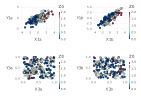

In [17]:
p1a = plot(data, x=:X1a, y=:Y1a, color=:Z0)
p1b = plot(data, x=:X1b, y=:Y1b, color=:Z0)
p3a = plot(data, x=:X3a, y=:Y3a, color=:Z0)
p3b = plot(data, x=:X3b, y=:Y3b, color=:Z0)
p6b = plot(data, x=:X6b, y=:Y6b, color=:Z0)
gridstack([p1a p1b; p3a p3b])

## Model selection

### Testing the sufficient condition for $X\to Y$

For the sufficient condition we have to test whether $Z$ is associated to $X$, $Z$ is associated to $Y$, and the association between $Z$ and $Y$ disappears after conditioning on $X$. If we assume linear models, these tests can be performed by standard least squares regression and testing for non-zero coefficients. Note that by construction $X$, $Y$ and $Z$ are samples from random variables with zero mean and hence we don't include an intercept in the regressions.

#### Testing data generated by Model 1a

First we do the regressions:

- regress $X$ on $Z$
- regress $Y$ on $Z$
- regress $Y$ on $X$ and store the residuals
- regress the residuals on $Z$

In [22]:
xg1a = lm(@formula(X1a ~ 0 + Z),data);
yg1a = lm(@formula(Y1a ~ 0 + Z),data);
yx1a = lm(@formula(Y1a ~ 0 + X1a),data);
data.residYX1a = residuals(yx1a);
ygx1a = lm(@formula(residYX1a ~ 0 + Z),data);

We can first analyze the results visually:

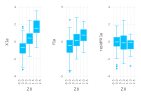

In [23]:
p1 = plot(data, x=:Z0, y=:X1a, Geom.boxplot)
p2 = plot(data, x=:Z0, y=:Y1a, Geom.boxplot)
p3 = plot(data, x=:Z0, y=:residYX1a, Geom.boxplot)
hstack(p1,p2,p3)

We see that $X$ and $Y$ are indeed associated with $Z$, whereas the residuals are not. We can confirm this by checking the p-values from the linear regressions:

In [33]:
xg1a

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

X1a ~ 0 + Z

Coefficients:
─────────────────────────────────────────────────────────────
     Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────
Z  1.14707    0.108386  10.58    <1e-20    0.93334     1.3608
─────────────────────────────────────────────────────────────

In [34]:
yg1a

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y1a ~ 0 + Z

Coefficients:
─────────────────────────────────────────────────────────────
      Coef.  Std. Error     t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────
Z  0.791762    0.142117  5.57    <1e-07   0.511513    1.07201
─────────────────────────────────────────────────────────────

In [35]:
ygx1a

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

residYX1a ~ 0 + Z

Coefficients:
────────────────────────────────────────────────────────────────
        Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────
Z  -0.0968272    0.110828  -0.87    0.3834  -0.315376   0.121721
────────────────────────────────────────────────────────────────

Clearly, the last result shows that the null hypothesis of no association between $Z$ and the residuals *cannot* be rejected, also seen from the fact that the 95% confidence interval *includes* zero (no effect).

Taken together these results show that $Z$ is associated with $X$, $Z$ is associated with $Y$, but $Z$ is not associated with $Y$ conditioned on $X$. This implies that we must have a causal relation $X\to Y$, because the only model compatible with these results is model 1a.

#### Testing data generated by Model 1b

We repeat the same procedure for the data generated by model 1b:

In [36]:
xg1b = lm(@formula(Y1b ~ 0 + Z),data)
yg1b = lm(@formula(Y1b ~ 0 + Z),data)
yx1b = lm(@formula(Y1b ~ 0 + X1b),data)
data.residYX1b = residuals(yx1b)
ygx1b = lm(@formula(residYX1b ~ 0 + Z),data);

Check the associations visually:

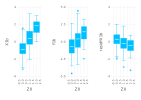

In [37]:
p1 = plot(data, x=:Z0, y=:X1b, Geom.boxplot)
p2 = plot(data, x=:Z0, y=:Y1b, Geom.boxplot)
p3 = plot(data, x=:Z0, y=:residYX1b, Geom.boxplot)
hstack(p1,p2,p3)

We see that $X$ and $Y$ are indeed associated with $Z$, but this time the residuals *also* seem to be associated with $Z$. We can confirm this by checking the p-values from the linear regressions:

In [38]:
xg1b

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y1b ~ 0 + Z

Coefficients:
─────────────────────────────────────────────────────────────
      Coef.  Std. Error     t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────
Z  0.889098     0.17975  4.95    <1e-05   0.534639    1.24356
─────────────────────────────────────────────────────────────

In [39]:
yg1b

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y1b ~ 0 + Z

Coefficients:
─────────────────────────────────────────────────────────────
      Coef.  Std. Error     t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────
Z  0.889098     0.17975  4.95    <1e-05   0.534639    1.24356
─────────────────────────────────────────────────────────────

In [40]:
ygx1b

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

residYX1b ~ 0 + Z

Coefficients:
───────────────────────────────────────────────────────────────
       Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────
Z  -0.439724    0.100917  -4.36    <1e-04  -0.638727   -0.24072
───────────────────────────────────────────────────────────────

The last result show that the null hypothesis of no association between $Z$ and the residuals must be *rejected*, in other words the residuals are *not* independent of $Z$.

Taken together these results show that $Z$ is associated with $X$, $Z$ is associated with $Y$, and $Z$ is associated with $Y$ conditioned on $X$. Many models are compatible with these results (which ones?), including some models with an interaction $X\to Y$ and some models with an interaction $Y\to X$. Hence we *cannot* conclude that $X\to Y$. 

#### Testing data generated by Model 6b

<div style="background-color:LightYellow; color:black">
<h3>Exercise</h3> 
      Repeat the steps above for the data generated from model 6b. What do you expect to find based on the causal diagram? What do you find?
</div>